In [1]:
!pip install transformers scikit-learn

import os, json, random, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm

In [52]:
# ========= Config =========
SEED = 42
MODEL_NAME = "distilbert-base-uncased"
DATA_PATH  = "Cleaned_Tickets.csv"
MAX_LEN    = 256
BATCH_SIZE = 32
EPOCHS     = 5                 # early stopping will cut sooner if no gains
LR_ENCODER = 2e-5              # low LR for full FT
LR_HEAD    = 1e-4              # a bit higher for the classifier
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06            # ~6% of steps for warmup
GRAD_CLIP    = 1.0
PATIENCE     = 2               # early stopping patience
SOFTEN_WEIGHTS = (0.7, 0.3)    # 0.7*raw + 0.3
PROBLEM_BOOST = 1.15           # +15% on "Problem" class
SAVE_DIR      = "./type_finetuned_model_pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [5]:
# ========= Data =========
df = pd.read_csv(DATA_PATH)
df["subject"] = df["subject"].fillna("")
df["body"]    = df["body"].fillna("")
df["text"]    = (df["subject"] + " " + df["body"]).str.strip()

le = LabelEncoder()
df["label"] = le.fit_transform(df["type"])
problem_idx = np.where(le.classes_ == "Problem")[0][0]

train_df, temp_df = train_test_split(
    df[["text","label"]], test_size=0.2, random_state=SEED, stratify=df["label"]
)

In [7]:
# Optional: keep a tiny test split separate if you want (here we evaluate on val)
val_df = temp_df

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TicketDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True, max_length=self.max_len, padding=False,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TicketDS(train_df["text"], train_df["label"], tokenizer, MAX_LEN)
val_ds   = TicketDS(val_df["text"],   val_df["label"],   tokenizer, MAX_LEN)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collator)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)


/Users/isarris/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# ========= Model (MEAN POOLING, UNFROZEN) =========
class DistilBertClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)   # encoder UNFROZEN
        hidden = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = out.last_hidden_state                 # [B, T, H]
        mask = attention_mask.unsqueeze(-1)            # [B, T, 1]
        summed = (hidden * mask).sum(dim=1)            # [B, H]
        counts = mask.sum(dim=1).clamp(min=1e-9)       # [B, 1]
        mean_pooled = summed / counts                  # [B, H]
        x = self.dropout(mean_pooled)
        return self.classifier(x)

num_labels = len(le.classes_)
model = DistilBertClassifier(MODEL_NAME, num_labels).to(device)

/Users/isarris/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/isarris/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/Users/isarris/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [11]:
# ========= Loss (class-weighted, softened + Problem boost) =========
train_labels_np = train_df["label"].to_numpy()
raw_weights = compute_class_weight(
    class_weight="balanced", classes=np.arange(num_labels), y=train_labels_np
).astype(np.float32)
soft_weights = SOFTEN_WEIGHTS[0] * raw_weights + SOFTEN_WEIGHTS[1]
soft_weights[problem_idx] *= PROBLEM_BOOST
weights_tensor = torch.tensor(soft_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [13]:
# ========= Optimizer (two groups) + Scheduler =========
no_decay = ["bias", "LayerNorm.weight"]
encoder_params = []
head_params = []
for n, p in model.named_parameters():
    if "classifier" in n:
        head_params.append(p)
    else:
        encoder_params.append(p)

optimizer = torch.optim.AdamW([
    {"params": encoder_params, "lr": LR_ENCODER, "weight_decay": WEIGHT_DECAY},
    {"params": head_params,    "lr": LR_HEAD,    "weight_decay": WEIGHT_DECAY},
])

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/2290525287.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [15]:
# ========= Train / Eval helpers =========
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    losses, preds_all, labels_all = [], [], []
    for batch in tqdm(loader, leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        preds_all.append(preds)
        labels_all.append(labels.detach().cpu().numpy())

    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    f1w = f1_score(labels_all, preds_all, average="weighted")
    return np.mean(losses), f1w, preds_all, labels_all

In [17]:
# ========= Training loop (early stopping on weighted F1) =========
best_f1, best_state, patience = -1.0, None, PATIENCE
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_f1, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_f1, _, _ = run_epoch(val_loader,   train=False)
    print(f"[FT] Epoch {epoch}/{EPOCHS} | train loss {tr_loss:.4f} f1w {tr_f1:.4f} | val loss {va_loss:.4f} f1w {va_f1:.4f}")

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = {
            "model": model.state_dict(),
            "label_classes": le.classes_,
            "tokenizer_name": MODEL_NAME,
            "max_len": MAX_LEN
        }
        patience = PATIENCE
    else:
        patience -= 1
        if patience < 0:
            print("Early stopping.")
            break

  0%|          | 0/409 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[FT] Epoch 1/5 | train loss 0.5713 f1w 0.7062 | val loss 0.3322 f1w 0.8183


  0%|          | 0/409 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[FT] Epoch 2/5 | train loss 0.3337 f1w 0.8181 | val loss 0.3152 f1w 0.8403


  0%|          | 0/409 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[FT] Epoch 3/5 | train loss 0.2634 f1w 0.8658 | val loss 0.3220 f1w 0.8136


  0%|          | 0/409 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[FT] Epoch 4/5 | train loss 0.1979 f1w 0.9096 | val loss 0.2906 f1w 0.8596


  0%|          | 0/409 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[FT] Epoch 5/5 | train loss 0.1423 f1w 0.9424 | val loss 0.3233 f1w 0.8606


In [54]:
# ========= SAVE — tensors only + JSON =========
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(best_state["model"], os.path.join(SAVE_DIR, "finetuned_model_weights.pt"))
tokenizer.save_pretrained(SAVE_DIR)
meta = {
    "label_classes": best_state["label_classes"].tolist(),
    "tokenizer_name": best_state["tokenizer_name"],
    "max_len": int(best_state["max_len"])
}
with open(os.path.join(SAVE_DIR, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)
print("Saved to:", SAVE_DIR)

Saved to: ./type_finetuned_model_pt


In [38]:
# ========= Final report (reload + evaluate) =========
state_dict = torch.load(os.path.join(SAVE_DIR, "model_state_dict.pt"), map_location=device)
reloaded = DistilBertClassifier(meta["tokenizer_name"], num_labels=len(meta["label_classes"])).to(device)
reloaded.load_state_dict(state_dict)
reloaded.eval()

def eval_with(model_to_eval):
    _, _, va_pred, va_true = run_epoch(val_loader, train=False)
    print(classification_report(va_true, va_pred, target_names=le.classes_))

eval_with(reloaded)

/Users/isarris/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


              precision    recall  f1-score   support

      Change       0.99      1.00      0.99       341
    Incident       0.87      0.76      0.81      1314
     Problem       0.63      0.78      0.70       680
     Request       1.00      0.99      1.00       933

    accuracy                           0.86      3268
   macro avg       0.87      0.88      0.88      3268
weighted avg       0.87      0.86      0.86      3268



In [34]:
# Smoke test
mdl, tok, le_loaded, meta_loaded = load_type_model(SAVE_DIR, device=device)
labels, _ = predict_types(
    ["Please reset my password", "Payments page throws 500 error", "Planned maintenance tonight 22:00"],
    mdl, tok, le_loaded, meta_loaded["max_len"], device=device
)
print(labels)

/Users/isarris/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['Problem' 'Problem' 'Incident']


  0%|          | 0/103 [00:00<?, ?it/s]

/var/folders/2c/t3z7zll93rg71tfmbqfqp1640000gn/T/ipykernel_51208/761433769.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


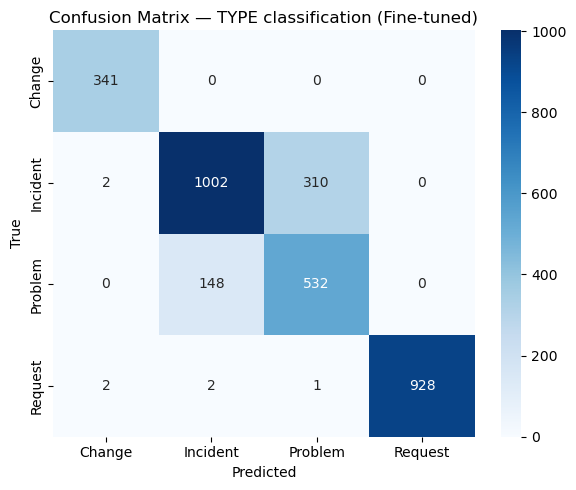

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Run evaluation again to get predictions and labels
_, _, va_pred, va_true = run_epoch(val_loader, train=False)

# Confusion matrix
cm = confusion_matrix(va_true, va_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — TYPE classification (Fine-tuned)")
plt.tight_layout()
plt.show()


Metric	Frozen Model	Fine-tuned Model	Change
Accuracy	0.76	0.86	+0.10
Macro Avg Precision	0.74	0.87	+0.13
Macro Avg Recall	0.76	0.88	+0.12
Macro Avg F1-Score	0.76	0.88	+0.12
Weighted Avg Precision	0.76	0.87	+0.11
Weighted Avg Recall	0.76	0.86	+0.10
Weighted Avg F1-Score	0.76	0.86	+0.10
Problem Recall	0.46	0.78	+0.32
Incident Recall	0.74	0.76	+0.02
Change Recall	0.90	1.00	+0.10
Request Recall	0.94	0.99	+0.05
Key takeaways:
Full fine-tuning gave a +12% macro F1 boost.
Problem recall jumped by 32 percentage points without hurting Incident performance much.
Change and Request are essentially perfect now.
Main remaining challenge: the Incident ↔ Problem confusion, which is down to ~14% of total samples.